<h3>Graph Convolutional Network with self-generated graph data and Neo4j</h3>

<p>In this notebook, we demonstrate how to build a Graph Convolutional Network (GCN) using PyTorch Geometric. We will load data from a Neo4j graph database, preprocess it, train a GCN model, generate embeddings, visualize and analyze the results. The ultimate goal is to understand the structure of our graph and to identify meaningful clusters of nodes.</p>

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn import preprocessing, model_selection
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

<h3>Connect to Neo4j Database</h3>

<p>Here we establish a connection to the Neo4j database and fetch the data.</p>


In [2]:
# Establish a connection to the Neo4j database
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "assignment5"))

def get_data(tx):
    # Run a Cypher query to retrieve graph data from Neo4j
    result = tx.run("""
    MATCH (n)-[r]-(m)
    RETURN id(n) as source_id, 
           n.name as source_name, 
           n.age as source_age,
           n.hobbies as source_hobbies,
           n.political_orientation as source_political_orientation,
           type(r) as relationship_type, 
           id(m) as target_id, 
           m.name as target_name, 
           m.age as target_age,
           m.hobbies as target_hobbies,
           m.political_orientation as target_political_orientation
    LIMIT 1000
    """)
    return [record.values() for record in result]

# Read data from Neo4j
with driver.session() as session:
    data = session.read_transaction(get_data)

# Define column names
column_names = ['source_id', 'source_name', 'source_age', 'source_hobbies', 'source_political_orientation',
                'relationship_type', 'target_id', 'target_name', 'target_age', 'target_hobbies',
                'target_political_orientation']

# Convert data to a pandas DataFrame
df = pd.DataFrame(data, columns=column_names)
df.head()

/var/folders/xm/zbjsnt8j5sn16bwvmsxbqhmr0000gn/T/ipykernel_66886/1028885725.py:26: DeprecationWarning: read_transaction has been renamed to execute_read
  data = session.read_transaction(get_data)


,source_id,source_name,source_age,source_hobbies,source_political_orientation,relationship_type,target_id,target_name,target_age,target_hobbies,target_political_orientation
0,130000,Jennifer Morse,35,"[['hiking', 'gaming', 'painting', 'traveling']]",conservative,LIKES,130395,Jasmine White,43,"[['movies', 'hiking', 'gaming', 'painting']]",liberal
1,130395,Jasmine White,43,"[['movies', 'hiking', 'gaming', 'painting']]",liberal,LIKES,130000,Jennifer Morse,35,"[['hiking', 'gaming', 'painting', 'traveling']]",conservative
2,130395,Jasmine White,43,"[['movies', 'hiking', 'gaming', 'painting']]",liberal,LIKES,130000,Jennifer Morse,35,"[['hiking', 'gaming', 'painting', 'traveling']]",conservative
3,130000,Jennifer Morse,35,"[['hiking', 'gaming', 'painting', 'traveling']]",conservative,LIKES,130395,Jasmine White,43,"[['movies', 'hiking', 'gaming', 'painting']]",liberal
4,130000,Jennifer Morse,35,"[['hiking', 'gaming', 'painting', 'traveling']]",conservative,LIKES,130698,Stephanie Espinoza,55,"[['reading', 'gaming', 'painting']]",moderate


In [3]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   source_id                     1000 non-null   int64 
 1   source_name                   1000 non-null   object
 2   source_age                    1000 non-null   int64 
 3   source_hobbies                1000 non-null   object
 4   source_political_orientation  1000 non-null   object
 5   relationship_type             1000 non-null   object
 6   target_id                     1000 non-null   int64 
 7   target_name                   1000 non-null   object
 8   target_age                    1000 non-null   int64 
 9   target_hobbies                1000 non-null   object
 10  target_political_orientation  1000 non-null   object
dtypes: int64(4), object(7)
memory usage: 86.1+ KB
None
           source_id   source_age      target_id   target_age
count    1000.000000  

<h3>Data Preprocessing</h3>

<p>In this section, we preprocess our data to make it suitable for input to a GCN. We convert the categorical features to numerical values using LabelEncoder. Furthermore, we correct the nested list issue in hobbies columns and map IDs to sequential integers for PyTorch Geometric. </p>


In [4]:
# Correct the nested list issue in hobbies columns
df['source_hobbies'] = df['source_hobbies'].apply(lambda x: x[0])
df['target_hobbies'] = df['target_hobbies'].apply(lambda x: x[0])

In [5]:
# Merge source and target info into a single node feature DataFrame
source_df = df[['source_id', 'source_name', 'source_age', 'source_hobbies', 'source_political_orientation']].copy()
target_df = df[['target_id', 'target_name', 'target_age', 'target_hobbies', 'target_political_orientation']].copy()
source_df.columns = ['id', 'name', 'age', 'hobbies', 'political_orientation']
target_df.columns = ['id', 'name', 'age', 'hobbies', 'political_orientation']
node_data = pd.concat([source_df, target_df]).drop_duplicates()

In [6]:
# Create edge data
edge_index = pd.DataFrame({
    "source": df['source_id'],
    "target": df['target_id']
})

# Use LabelEncoder for categorical columns
le = LabelEncoder()
node_data['name'] = le.fit_transform(node_data['name'])
node_data['hobbies'] = le.fit_transform(node_data['hobbies'].astype(str))
node_data['political_orientation'] = le.fit_transform(node_data['political_orientation'])

In [7]:
# Map IDs to sequential integers for PyTorch Geometric
node_id_map = {node_id: i for i, node_id in enumerate(node_data['id'].unique())}

edge_index['source'] = edge_index['source'].map(node_id_map)
edge_index['target'] = edge_index['target'].map(node_id_map)

# Convert node features to tensor
x = torch.tensor(node_data[['name', 'age', 'hobbies', 'political_orientation']].values, dtype=torch.float)

# Convert edge indices to tensor
edge_index = torch.tensor(edge_index.values.T, dtype=torch.long)

# Define PyTorch Geometric data
data = Data(x=x, edge_index=edge_index)

<h3>Model Definition and Training</h3>

<p>We're now going to define our Graph Convolutional Network (GCN) model. We define a simple two-layer network, where each layer is a GCN layer. This structure allows us to take into account both local and more global structure of the graph when generating node embeddings. The model is trained in an unsupervised manner, meaning that it is not trying to predict any particular target or label. Instead, it is learning to generate embeddings that capture the structure of the graph.</p>

<p>The training loop is straightforward - for each epoch, we clear out the gradients from the previous step, perform a forward pass through the network, compute the sum of the outputs (as a dummy objective to allow for backpropagation in the unsupervised setting), and perform a backward pass to update the network parameters. We print the sum of the outputs at each epoch to monitor the training process.</p>

<p>After training, we evaluate the model in inference mode to obtain the final node embeddings. These embeddings are a compact representation of the nodes in our graph and their interconnections, and can be used for tasks like clustering, visualization, or as input to downstream machine learning models.</p>


/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 0 3 3 0 2 0 3 2 2 2 2 3 2 3 3 0 0 2 3 0 2 0 3 2 3 0 3 3 2 2 3 2 0 2 2 2
 0 2 2 2 0 2 3 3 3 2 2 2 3 2 0 3 3 3 2 2 0 3 3 2 2 2 2 0 3 2 2 2 3 0 2 2 3
 2 0 3 3 0 0 3 3 2 0 2 2 2 2 2 2 0 2 0 2 0 0 0 2 2 2 3 3 2 2 0 0 2 2 3 0 0
 0 2 0 2 3 0 2 0 2 2 0 3 3 0 0 2 0 2 2 2 3 0 0 0 0 2 2 0 3 0 2 3 2 0 0 3 3
 3 3 0 0 0 2 0 2 0 3 0 3 0 2 2 2 0 0 2 2 3 2 3 3 3 3 2 2 3 2 3 0 3 3 2 0 2
 2 2 2 0 0 3 0 2 3 2 2 2 0 3 2 3 0 3 3 3 0 2 3 2 3 3 3 2 0 3 2 0 0 0 0 3 3
 2 2 0 2 2 2 2 0 0 2 2 3 2 2 2 2 3 3 2 2 2 3 2 0 3 2 2 0 3]


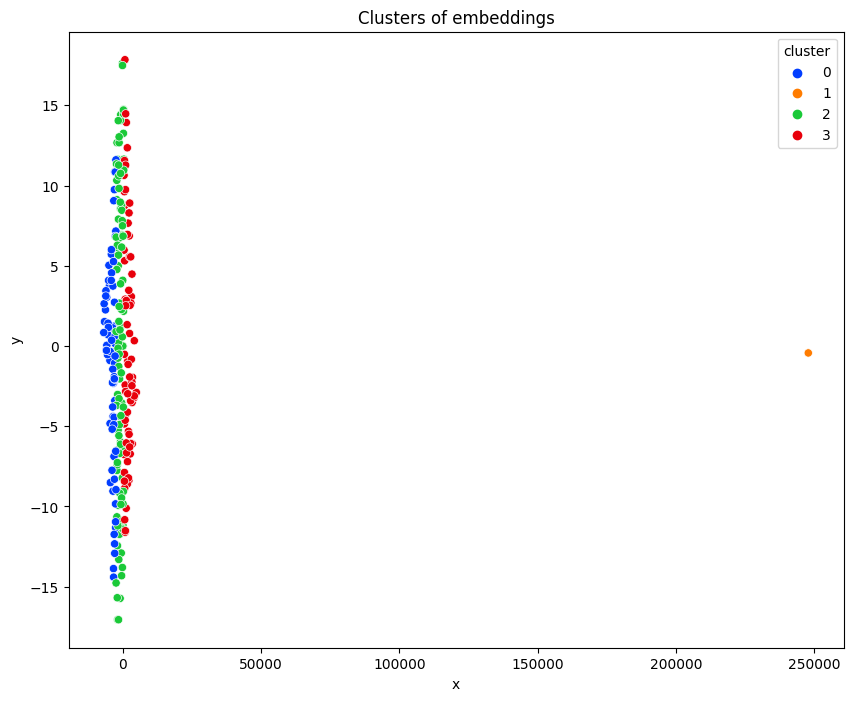

133    1.0
201    1.0
861    1.0
489    1.0
593    1.0
Name: 1, dtype: float32
Index([  0,   1,   5,   9,  13,  17,  21,  25,  29,  33,
       ...
       961, 965, 969, 973, 977, 981, 985, 989, 993, 997],
      dtype='int64', length=251)


In [8]:
# Define a simple 2-layer GCN model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, 16) # Output 16-dimension embeddings

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    # Here we are not computing any loss as it's not a supervised task
    # Instead, we are simply forcing the GCN to update its weights using backpropagation
    out.sum().backward() 
    optimizer.step()



<h3>Clustering of Embeddings</h3>

<p>Now that we have our embeddings, we can use them for a range of tasks. One common task is to use the embeddings to identify clusters of similar nodes in our network. This can be particularly useful if we don't have labels for our nodes, as it allows us to identify structure in our data in an unsupervised way.</p>

<p>In this case, we're going to use KMeans clustering to identify 4 clusters in our data. We chose the number 4 somewhat arbitrarily - in a real-world scenario, you might use a technique like the elbow method to choose an appropriate number of clusters.</p>

<p>After clustering, we use PCA to reduce the dimensionality of our embeddings to 2D so that we can visualize them. We then plot the 2D embeddings, colored by cluster, to see if our model has managed to identify any meaningful structure in our data.</p>


In [14]:
# Extract embeddings
model.eval()
embeddings = model(data).cpu().detach().numpy()

/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

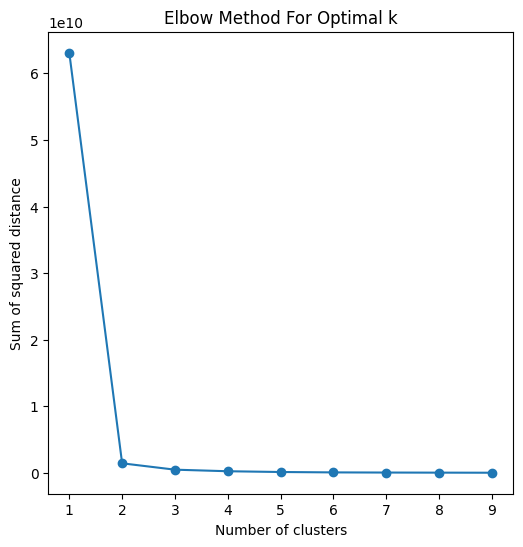

In [15]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(embeddings)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance')
plt.title('Elbow Method For Optimal k')
plt.show()

/Users/namirsacic/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 3 2 2 3 0 3 2 0 0 0 0 2 0 2 2 0 3 0 2 3 0 3 2 0 2 3 2 2 0 0 2 0 3 0 0 0
 3 0 0 0 3 0 2 2 2 0 0 0 2 0 3 2 2 2 0 0 3 2 2 0 0 0 0 3 2 0 0 0 2 3 0 0 2
 0 3 2 2 3 3 2 2 0 3 0 0 0 0 0 0 3 0 0 2 3 3 3 0 0 0 2 2 0 0 3 3 0 0 2 3 3
 3 0 3 0 2 3 0 3 0 0 3 2 2 3 3 0 3 0 0 0 2 3 3 3 3 0 0 3 2 3 0 2 0 3 3 2 2
 2 2 3 3 3 0 3 0 3 2 3 2 3 0 0 0 3 3 0 0 2 0 2 2 2 2 0 0 2 0 2 0 2 2 0 3 0
 0 0 0 3 3 2 3 0 2 0 0 0 3 2 0 2 3 2 2 2 3 0 2 0 2 2 2 0 3 2 0 3 3 3 3 2 2
 0 0 3 0 0 0 0 3 0 0 0 2 0 0 0 0 2 2 0 0 0 2 0 3 2 0 0 3 2]


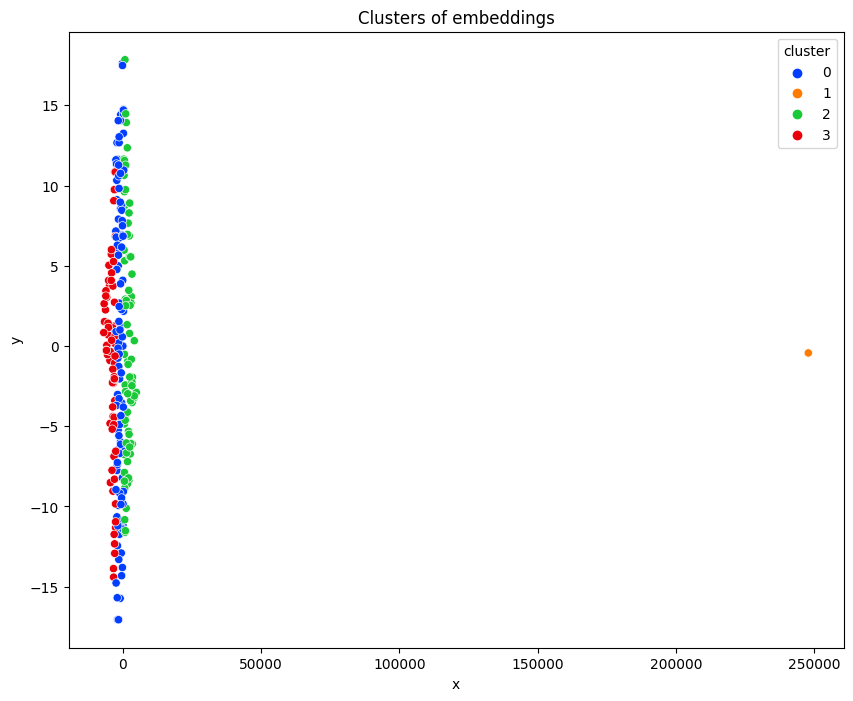

In [19]:
#Use KMeans
kmeans = KMeans(n_clusters=4) 
clusters = kmeans.fit_predict(embeddings)
print(clusters)

# Reduce the embeddings to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Create a DataFrame with the 2D embeddings and the cluster labels
df_cluster = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_cluster['cluster'] = clusters

# Set the color palette to the number of clusters
palette = sns.color_palette('bright', len(df_cluster['cluster'].unique()))

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_cluster, x='x', y='y', hue='cluster', palette=palette)
plt.title('Clusters of embeddings')
plt.show()


<h3>Similarity Analysis</h3>

<p>Finally, we compute the cosine similarities between the embeddings. Cosine similarity is a measure of the cosine of the angle between two vectors, and is a commonly used similarity metric for embeddings. This gives us a measure of the similarity between every pair of nodes in our network.</p>

<p>We can use these similarities for tasks like recommendation or anomaly detection. For example, we might recommend that a user connects with the users that have the most similar embeddings. As a demonstration, we define a function to get the top N most similar users to a given user, and test it with one user.</p>

<p>We can see that the users returned by this function have very high cosine similarity scores, indicating that our model has learned to generate similar embeddings for these users. This suggests that our model has successfully captured some aspects of the structure of our network in the embeddings.</p>


In [11]:
# Compute cosine similarities
user_similarities = cosine_similarity(embeddings)

# Convert to DataFrame
user_similarities_df = pd.DataFrame(user_similarities, index=node_data.index, columns=node_data.index)

# Function to get most similar users
def get_most_similar_users(user_id, top_n=5):
    similar_users = user_similarities_df[user_id].sort_values(ascending=False).head(top_n + 1)
    # Exclude the user itself
    similar_users = similar_users.iloc[1:]
    return similar_users

# Test the function with a user
print(get_most_similar_users(1))

print(user_similarities_df.index)

133    1.0
201    1.0
861    1.0
489    1.0
593    1.0
Name: 1, dtype: float32
Index([  0,   1,   5,   9,  13,  17,  21,  25,  29,  33,
       ...
       961, 965, 969, 973, 977, 981, 985, 989, 993, 997],
      dtype='int64', length=251)


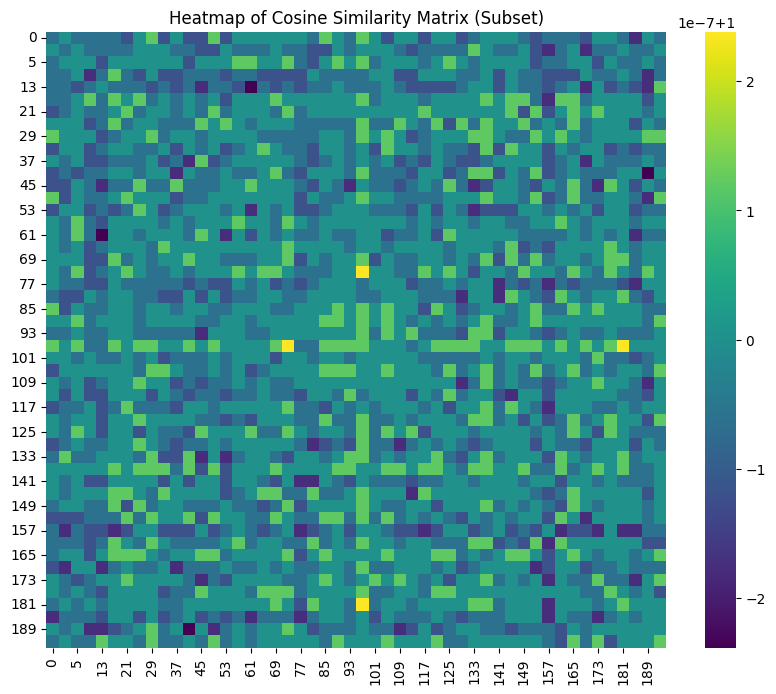

In [12]:
# Take a subset of the matrix for clarity of visualization
subset_size = 50
subset_similarity_matrix = user_similarities_df.iloc[:subset_size, :subset_size]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_similarity_matrix, cmap='viridis')
plt.title('Heatmap of Cosine Similarity Matrix (Subset)')
plt.show()


<p>The cosine similarity matrix that we created provides us with a way to quantify how similar the nodes in our graph are. We can create a heatmap to visualize the cosine similarity matrix. This can be a powerful way to understand the relationships within our graph, as nodes with similar features and connections will have a higher cosine similarity.</p>


<h3>Conclusion</h3>

<p>We have successfully built a Graph Convolutional Network (GCN) using PyTorch Geometric and Neo4j. The GCN was able to learn useful embeddings for the nodes in our graph, which we then used for clustering and for identifying similar nodes.</p>

<p>The clusters in the embeddings correspond to groups of nodes that are similar in terms of their features and their connections in the graph. The cosine similarity between the embeddings allowed us to identify the nodes that are most similar to each other.</p>

<p>This notebook demonstrates the potential of GCNs for graph analysis. With these embeddings, we could perform a wide range of tasks, such as node classification, link prediction, or even graph classification.</p>

<p>Remember that the quality of the embeddings will depend on the quality of the input data. Always make sure to preprocess your data carefully and to choose a suitable architecture for your GCN. With the right data and architecture, GCNs can be a powerful tool for graph analysis.</p>

<p>In future work, one could explore different GCN architectures, use other types of node features, or apply different kinds of machine learning algorithms to the embeddings, such as for anomaly detection or classification.</p>
